In [ ]:
import random
import pandas as pd
import numpy as np
import import_ipynb
import GenFeatures
import itertools
from sklearn import metrics
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB

importing Jupyter notebook from GenFeatures.ipynb


In [ ]:
i2b2_hipaa = pd.read_pickle("i2b2_df_matched.p")
nz_hipaa = pd.read_pickle("nz_data_df_new.p")
toremove = set(i2b2_hipaa.tags.unique()) - set(nz_hipaa.tags.unique())
i2b2_hipaa.loc[(i2b2_hipaa.tags.isin(toremove)),'tags']='O'   
i2b2_hipaa = i2b2_hipaa[i2b2_hipaa['token']!= ' '].copy()

classCount = nz_hipaa.groupby('tags',as_index=False).count()
classorder = list(classCount['tags'])

def toGroups(object):
    x = lambda s: list(zip(s["token"].tolist(), s["pos"].tolist(), s["tags"].tolist()))
    grouped = object.groupby('sent_id')['token','pos','tags'].apply(x)
    return list(grouped)

ob = GenFeatures.features()
def getFeatureLabels(data):
    features = [ob.sent2features(s) for s in data]
    labels = [ob.sent2labels(s) for s in data]
    return features,labels

i2b2group = toGroups(i2b2_hipaa)
nzgroup = toGroups(nz_hipaa)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


### Steps

1. Train Naive Bayes on NZ data step by step.
2. Train CRF on i2b2 data.
3. Predict weights using step by step data.
4. Get the combined output

In [ ]:
def flatten(flData):
    Xdata = list(itertools.chain.from_iterable(flData[0]))
    Ydata = list(itertools.chain.from_iterable(flData[1]))
    return Xdata,Ydata

def getBatch(gdata, n=1):
    l = len(gdata)
    for ndx in range(0, l, n):
        yield gdata[ndx:ndx+n]

def predCRF(testData, model):
    pred = model.predict(testData[0])
    predProb = model.predict_marginals(testData[0])
    predReal = flatten((pred,testData[1]))
    f1score = metrics.f1_score(predReal[0],predReal[1], average='macro')
    predProb = list(itertools.chain.from_iterable(predProb))
    dfProb = pd.DataFrame(predProb)
    dfProb = dfProb.reindex(columns=classorder)
    dfProb = dfProb.fillna(0)
    return f1score,dfProb

def predNaive(testData,vectorizer, model):
    Xdata,Ydata = flatten(testData)
    Xdata = vectorizer.transform(Xdata)
    pred = model.predict(Xdata)
    predprob = model.predict_proba(Xdata)
    f1score = metrics.f1_score(pred,Ydata, average='macro')
    dfProb = pd.DataFrame.from_records(predprob, columns = model.classes_)
    dfProb = dfProb.reindex(columns=classorder)
    return f1score,dfProb

def encodedY(chunkfl):
    Xdata,Ydata = flatten(chunkfl)
    dfY = pd.get_dummies(Ydata)
    dfY = dfY.reindex(columns=classorder)
    dfY = dfY.fillna(0)
    ty = np.array(dfY)
    return ty

def estWeights(CRFmodel,NBmodel,vectorizer,chunkData):
    chunkFl = getFeatureLabels(chunkData)
    f1 = predCRF(chunkFl,CRFmodel)
    f2 = predNaive(chunkFl,vectorizer,NBmodel)
    print("CRF: ",f1[0])
    print("Naive: ",f2[0])
    af1 = np.array(f1[1])
    af2 = np.array(f2[1])
    y = encodedY(chunkFl)
    w = sum(sum((y-af2)*(af1-af2)))/sum(sum(((af1-af2)**2)))
    if w > 1:
        w = 1
    elif w < 0:
        w = 0
    print(w)
    return w
    
def predEnsemble(f1, f2, testData, w):
    Xdata,Ydata = flatten(testData)
    predprob = (w*f1)+((1-w)*f2)
    pred=predprob.idxmax(axis=1)
    f1score = metrics.f1_score(Ydata, list(pred), average='macro')
    return f1score, predprob
    
def trainNaive(model,vectorizer,data):
    dataFl = getFeatureLabels(data)
    Xdata,Ydata = flatten(dataFl)
    Xdata = vectorizer.transform(Xdata)
    model.partial_fit(Xdata,Ydata,classorder)
    return model

def trainCRF(model,trainData,chunkData):
    cdataFl = getFeatureLabels(chunkData)
    trainData[0].extend(cdataFl[0])
    trainData[1].extend(cdataFl[1])
    print("Training CRF Model:",len(trainData[0]))
    model.fit(trainData[0],trainData[1])
    return model, trainData

def runModel(i2b2, crfModel, data, vectorizer, testData):
    clfNB = MultinomialNB(alpha = 0.001)
    f1crfs,f1NBs,f1ensemble = list(),list(),list()
    weights = list()
    batchIter = getBatch(data, n=30)
    trainData = [[],[]]
    #trainData = i2b2 #Uncomment this to initially train on i2b2
    prevChunk = list()
    for idx, chunk in enumerate(batchIter):
        #train Models on prev chunk.
        if idx == 0:
            prevChunk = chunk
        else:        
            print("Processing Chunk: ",idx)
            naiveModel = trainNaive(clfNB,vectorizer,prevChunk)
            crfModel,trainData = trainCRF(crfModel,trainData,prevChunk)
            NBpreds = predNaive(testData,vectorizer,naiveModel)
            CRFpreds = predCRF(testData, crfModel)
            weight = estWeights(crfModel,naiveModel,vectorizer,chunk)
            Epreds = predEnsemble(CRFpreds[1],NBpreds[1],testData, weight)
            f1NBs.append(NBpreds[0])
            f1crfs.append(CRFpreds[0])
            f1ensemble.append(Epreds[0])
            weights.append(weight)
            prevChunk = chunk
    return f1crfs,f1NBs,f1ensemble,weights

In [ ]:
i2b2Fl = getFeatureLabels(i2b2group[0:10000])
flat_i2b2Fl = flatten(i2b2Fl)
vectorizer = DictVectorizer(sparse=False)
vectorizer.fit(flat_i2b2Fl[0])

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
crf = CRF(max_iterations=100, c1=0.4,c2=0.4, verbose=False)
madeData = list()
for i in range(0,20):
    init_i2b2 = (i2b2Fl[0].copy(),i2b2Fl[1].copy())
    trainNZ, testNZ = train_test_split(nzgroup, test_size=0.20)
    testNZfl = getFeatureLabels(testNZ)
    modelOutputs = runModel(init_i2b2,crf,trainNZ,vectorizer,testNZfl)
    madeData.append(modelOutputs)

Processing Chunk:  1
Training CRF Model: 30
CRF:  0.07876440206595153
Naive:  0.11070125512200053
0.8712421880426174
Processing Chunk:  2
Training CRF Model: 60
CRF:  0.3717556671230792
Naive:  0.44742281527995814
0.8670419529605298
Processing Chunk:  3
Training CRF Model: 90
CRF:  0.5264877113697718
Naive:  0.5345305279515805
0.7191358017457107
Processing Chunk:  4
Training CRF Model: 120
CRF:  0.6939214081047892
Naive:  0.4594674473961871
0.8284625055970071
Processing Chunk:  5
Training CRF Model: 150
CRF:  0.40780474765817254
Naive:  0.4637417076577279
0.855442751863795
Processing Chunk:  6
Training CRF Model: 180
CRF:  0.7285789844851904
Naive:  0.5361904761904762
0.8328787143573851
Processing Chunk:  7
Training CRF Model: 210
CRF:  0.4758749126413968
Naive:  0.44747284878863824
0.8665991240990963
Processing Chunk:  8
Training CRF Model: 240
CRF:  0.5995394187222443
Naive:  0.36693049091494867
0.9779273504955173
Processing Chunk:  9
Training CRF Model: 270
CRF:  0.6219040277863807


In [ ]:
unwrap = list(zip(*madeData))
unwrap_each = map(lambda x: list(zip(*x)), unwrap)
new = list(unwrap_each)

In [ ]:
from scipy.stats import sem, t
from scipy import mean
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return m-h, m, m+h

In [ ]:
getconfint = lambda x: list(map(mean_confidence_interval, x))
confints = list(map(getconfint,new))
eachconfints = map(lambda x: list(zip(*x)),confints)
expresult = list(eachconfints)

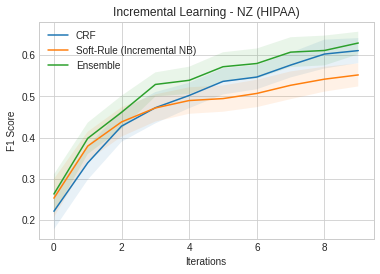

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
label = ['CRF','Soft-Rule (Incremental NB)','Ensemble']
for i in range(0,3):
    y = expresult[i][1]
    y1 = expresult[i][0]
    y2 = expresult[i][2]
    xval = list(range(0,len(y)))
    plt.plot(xval,y, '-', label=label[i])
    plt.fill_between(xval, y1, y2, alpha=0.1)
plt.legend(loc='upper left')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.title('Incremental Learning - NZ (HIPAA)')
plt.draw()
plt.savefig('NZ-HIPAA2.svg')
plt.show()

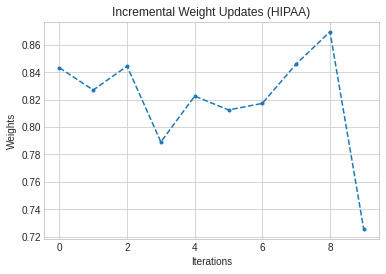

In [ ]:
plt.scatter(range(0,len(expresult[3][1])),expresult[3][1], marker='.')
plt.plot(expresult[3][1], linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Weights')
plt.title('Incremental Weight Updates (HIPAA)')
plt.rcParams["figure.figsize"] = (6,4)
plt.draw()
plt.savefig('Weights-HIPAA.svg')
plt.show()